<a href="https://colab.research.google.com/github/zahidcv/OCT-Image-Denoising/blob/main/OCT_Image_Denoiser_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing & setting up device

In [1]:
import os, shutil
from os.path import join, isdir
from os import mkdir, makedirs
import cv2
import sys
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
try:
  from torchsummary import summary
except:
  !pip install torchsummary
  from torchsummary import summary



In [2]:
# Find Out if the code is running in Google Colab

COLAB = 'google.colab' in sys.modules

#setting up Device for device agnostic code

if torch.cuda.is_available():
    DEVICE = "cuda"
# elif torch.mps.backened.is_available():
#     DEVICE = "mps"
else:
    DEVICE = "cpu"
    
print(DEVICE)

cuda


In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    if not isdir("/content/Patch OCT Dataset"):
        print("Downloading train dataset")
        !pip install -U --no-cache-dir gdown --pre    
        !gdown 1nmld3mwrm1Sxij0Bv9idhcQBM27HhbPn
        !unzip '/content/Patch OCT Dataset.zip' 
    
    # if not isdir("/content/Test_Set"):
    #     print("Downloading Test dataset")
    #     !pip install -U --no-cache-dir gdown --pre    
    #     !gdown 1igwzf0HvwdfHE6J_ay0dkHZDPiOdakI8
        # !unzip '/content/Test_Set.zip' 
    if not isdir("/content/Test_Set2"):
        print("Downloading Test dataset")
        !pip install -U --no-cache-dir gdown --pre    
        !gdown 1ieBkYM-W-qHwoVVYGOHPyZKGH6lZiVGI
        !unzip '/content/Test_Set2.zip' 

    if not isdir("/content/Models"):    
        print("Downloading Model")
        !pip install -U --no-cache-dir gdown --pre    
        !gdown 1Ggd_kuMe1JDx7idw8co24r03V_aWUTf- 
    

    run_path = '/content/runs/OCT Denoise'
    from distutils.dir_util import copy_tree
    copy_tree("/content/drive/MyDrive/Research/runs", run_path)
    # https://drive.google.com/file/d/1Ggd_kuMe1JDx7idw8co24r03V_aWUTf-/view?usp=share_link
  # https://drive.google.com/file/d/1nmld3mwrm1Sxij0Bv9idhcQBM27HhbPn/view?usp=sharing

  #Test Seet 1
  # https://drive.google.com/file/d/1igwzf0HvwdfHE6J_ay0dkHZDPiOdakI8/view?usp=sharing
  #Test set 2
  #https://drive.google.com/file/d/1ieBkYM-W-qHwoVVYGOHPyZKGH6lZiVGI/view?usp=sharing
  # !unzip '/content/Patch OCT Dataset.zip'
    # https://drive.google.com/drive/folders/1mzKJGFe43DJF6-XVLmBlWK2CLyRbV8mW?usp=sharing
    # https://drive.google.com/drive/folders/1mzKJGFe43DJF6-XVLmBlWK2CLyRbV8mW?usp=sharing
    # https://drive.google.com/drive/u/1/folders/1mzKJGFe43DJF6-XVLmBlWK2CLyRbV8mW
    #   from google.colab import drive
#   drive.mount('/content/drive')
  
#   # Defining Data Path
#   Root_Dir = '/content/drive/MyDrive/Research/OCT datasets'

In [4]:
!nvidia-smi

Wed Oct 18 15:25:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 31%   44C    P8     8W / 151W |    130MiB /  8192MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading dataset

## Content Data paths

In [5]:
if COLAB:
    patch_data_dir = '/content/Patch OCT Dataset'
elif DEVICE == 'mps':
    pass
else:
    content_data_dir = r"C:\Users\HP\Documents\Zahid\Style Transfer\Datasets\val2017"
    
CONTENT_IMAGE_PATHS = []

for img in sorted(os.listdir(content_data_dir)):
    
    if img[0] == '.':
        continue
        
    content_img_path = join(content_data_dir, img)
    CONTENT_IMAGE_PATHS.append(content_img_path)



# Style data path

In [6]:
if COLAB:
    patch_data_dir = '/content/Patch OCT Dataset'
elif DEVICE == 'mps':
    pass
else:
    style_data_dir = r"C:\Users\HP\Documents\Zahid\Style Transfer\Datasets\style\Rudraneil"
    
STYLE_IMAGE_PATHS = []

for img in sorted(os.listdir(style_data_dir)):
    
    if img[0] == '.':
        continue
        
    style_img_path = join(style_data_dir, img)
    STYLE_IMAGE_PATHS.append(style_img_path)



In [7]:
print(len(STYLE_IMAGE_PATHS))
print(len(CONTENT_IMAGE_PATHS))

14
5000


## Test Data Paths

In [8]:
# if COLAB:
#     test_data_dir = '/content/Test_Set'
# elif DEVICE == 'mps':
#     pass
# else:
#     test_data_dir = r"C:\Users\HP\Documents\Zahid\OCT\DATASET\Patch Test OCT Dataset"


# clean_data_dir = join(test_data_dir, 'Clean')
# noisy_data_dir = join(test_data_dir, 'Noisy')
# TEST_IMAGE_PATHS = []

# for folder in sorted(os.listdir(clean_data_dir)):
    
#     if folder[0] == '.':
#         continue
    
#     clean_folder_path = join(clean_data_dir, folder)
#     noisy_folder_path = join(noisy_data_dir, folder)
#     # print(current_folder_path)
#     for img in sorted(os.listdir(clean_folder_path)):
#         if img[0] == '.':
#             continue
#         # print(img)

#         clean_img_path = join(clean_folder_path, img)
#         noisy_img_path = join(noisy_folder_path, img)

#         TEST_IMAGE_PATHS.append([noisy_img_path, clean_img_path])
#         # print(clean_img_path, noisy_img_path)





# Util Functions

In [9]:
def about(data):
  typ = type(data)
  print(typ)

  if typ == list:
    print(len(data))
  else:
    print(data.shape)

## Colors

In [10]:
class bcolors:
  HEADER = '\033[95m'
  OKBLUE = '\033[94m'
  OKCYAN = '\033[96m'
  OKGREEN = '\033[92m'
  WARNING = '\033[93m'
  FAIL = '\033[91m'
  ENDC = '\033[0m'
  BOLD = '\033[1m'
  UNDERLINE = '\033[4m'

In [11]:
print(f"{bcolors.UNDERLINE} und")

 und


## Del_contents()

In [12]:
import os, shutil
def del_contents(path):
  folder = path
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

## Show_images()

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(images):

# create a figure with X rows and 4 columns
  cols = 4
  rows = len(images)//cols
  fig, axs = plt.subplots(rows, cols, figsize=(12, 3*rows))
  idx = 0
  for i in range(rows):
    for j in range(cols):
        ax = axs[i, j]
        # plot your image using ax.imshow() or any other plotting function
        ax.imshow(images[idx], cmap = 'gray')
        # add titles, labels, etc.
        ax.set_title(f"Image {i*4 + j + 1}")
        plt.axis('off')
        idx+=1
  fig.tight_layout()
  plt.show()


## Show_sample()

In [14]:
def show_sample():
  test_noisy_image = n.to(DEVICE)

  gen_clean_image = generator(test_noisy_image.unsqueeze(dim=1)).squeeze()
  real_clean_image = c
  print()
  fig = plt.figure(figsize = (10,10))

  with torch.inference_mode():
    fig.add_subplot(1,3,1)
    plt.imshow(test_noisy_image.squeeze().to('cpu'), cmap='gray')
    plt.title("Real Noisy Image")
    plt.axis('off')

    fig.add_subplot(1,3,2)
    plt.imshow(gen_clean_image.to('cpu'), cmap='gray')
    plt.title("Fake Clean Image")
    plt.axis('off')

    fig.add_subplot(1,3,3)
    plt.imshow(real_clean_image.squeeze(), cmap='gray')
    plt.title("Real Clean Image")
    plt.axis('off')

    plt.show()

## Show_sample_with_param()

In [15]:
def show_sample_with_param(n, c, gen_clean_image):
  """
  N, c , gen
  """
  test_noisy_image = n.to(DEVICE)
  gen_clean_image = gen_clean_image.squeeze()
  real_clean_image = c

  fig = plt.figure(figsize = (10,10))

  with torch.inference_mode():
    fig.add_subplot(1,3,1)
    plt.imshow(test_noisy_image.squeeze().to('cpu'), cmap='gray')
    plt.title("Real Noisy Image")
    plt.axis('off')

    fig.add_subplot(1,3,2)
    plt.imshow(gen_clean_image.to('cpu'), cmap='gray')
    plt.title("Fake Clean Image")
    plt.axis('off')

    fig.add_subplot(1,3,3)
    plt.imshow(real_clean_image.squeeze(), cmap='gray')
    plt.title("Real Clean Image")
    plt.axis('off')

    plt.show()

#  Datasets and Dataloaders

## Creating Dataset

### Custom Dataset Class

In [16]:
class CustomDataset(Dataset):

  def __init__(self, paths, transform = None):
    self.paths = paths
    self.transform = transform

  def __getitem__(self, index:int, ):

    img = Image.open(self.paths[index]).convert('RGB')
    
    if self.transform:
      return self.transform(img)

    return img



  def __len__(self):
    return len(self.paths)


### Transformations

In [17]:
# defining Transforms Needed to be done on the Images
img_size = 224
trans = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5)),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])


### Dataset Instance

In [18]:
# Dataset 
content_dataset = CustomDataset(CONTENT_IMAGE_PATHS, transform = trans)
print(len(content_dataset))

style_dataset = CustomDataset(STYLE_IMAGE_PATHS, transform = trans)
print(len(style_dataset))

5000
14


In [19]:
content_dataset[0].shape

torch.Size([3, 224, 224])

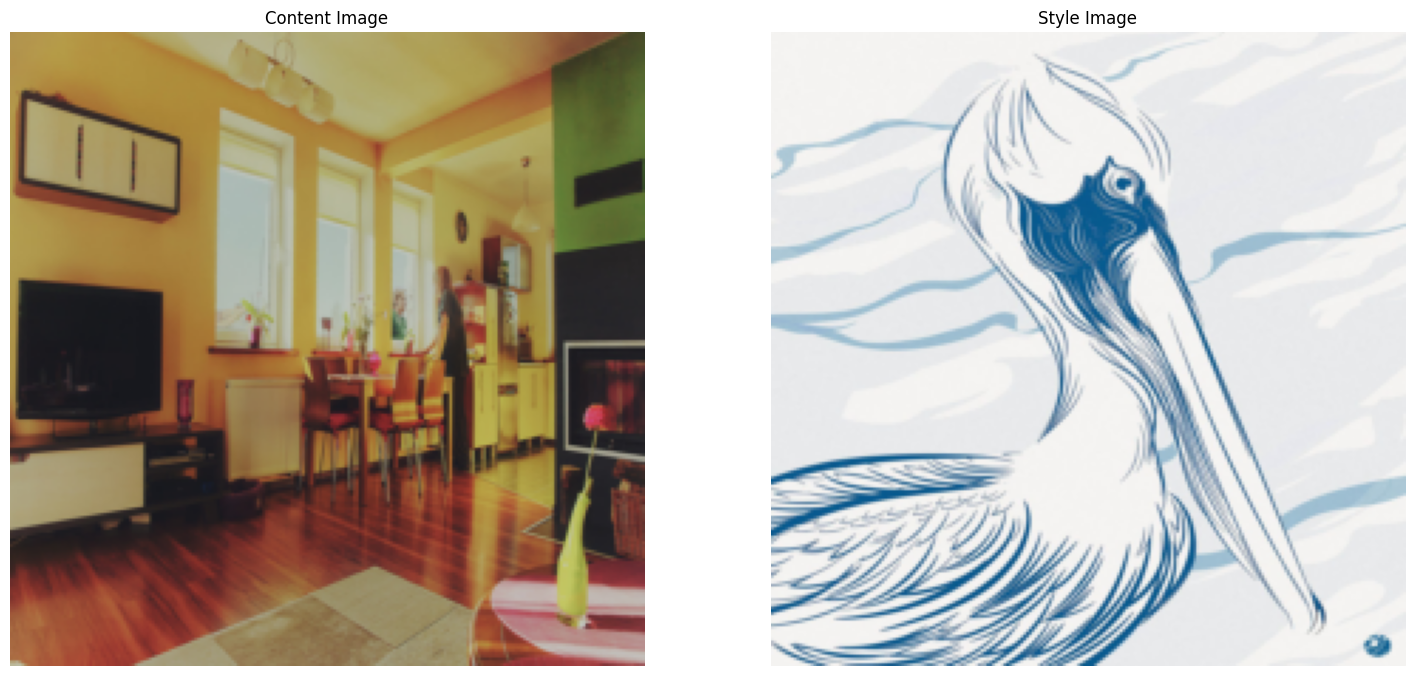

In [20]:
plt.figure(figsize = (18,18))
plt.subplot(1,2,1)
plt.imshow(content_dataset[0].permute(1,2,0))
plt.title('Content Image')
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(style_dataset[0].permute(1,2,0))
plt.title('Style Image')
plt.axis("off")

c,s = content_dataset[0], style_dataset[0]

In [21]:
s.max()

tensor(0.9765)

(-0.5, 223.5, 223.5, -0.5)

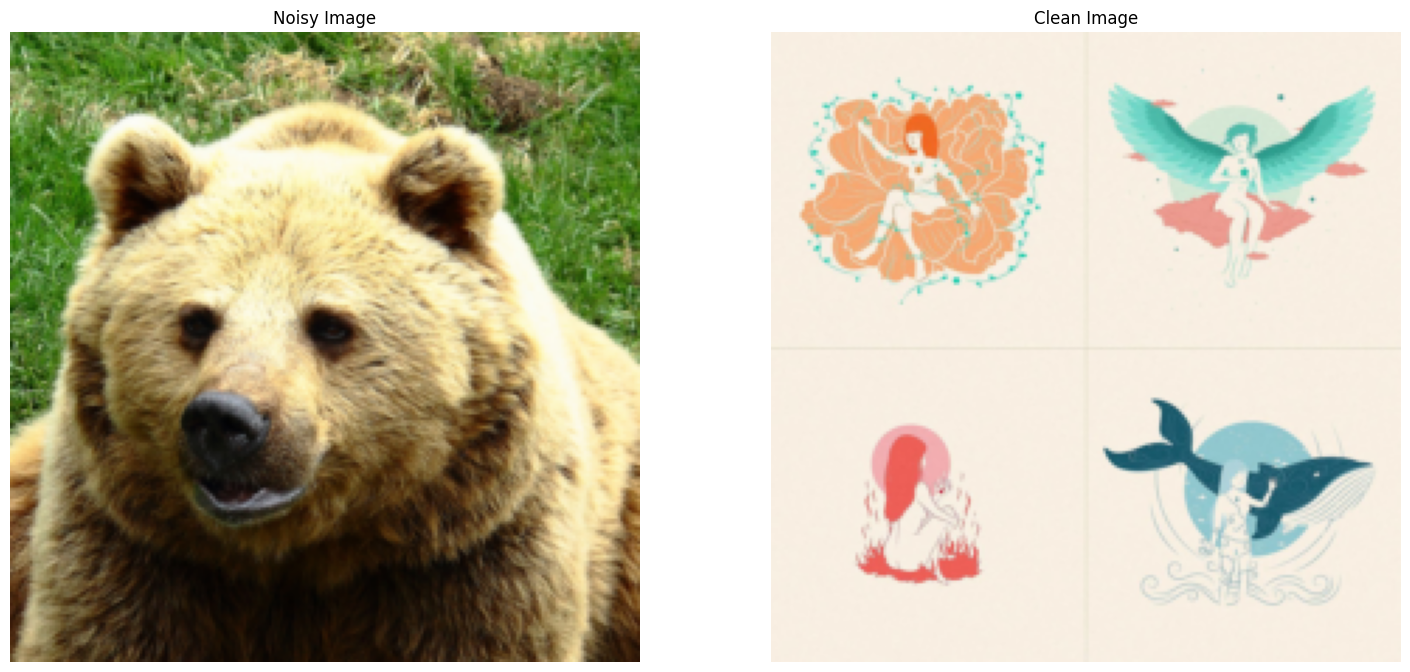

In [22]:

c2, s2 = content_dataset[1], style_dataset[1]
plt.figure(figsize = (18,18))

plt.subplot(2,2,3)
plt.imshow(c2.squeeze().permute(1,2,0))
plt.title('Noisy Image')
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(s2.squeeze().permute(1,2,0))
plt.title('Clean Image')
plt.axis("off")



## BATCH SIZE

In [23]:
BATCH_SIZE = 16
IMG_SIZE = 224

## Data Loader

In [24]:
content_dl = DataLoader(content_dataset, batch_size = BATCH_SIZE, shuffle = True,)
style_dl = DataLoader(style_dataset, batch_size = BATCH_SIZE, shuffle = True,)


In [25]:
for content_images in content_dl:
    print(content_images.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size

In [26]:
for style_images in style_dl:
    print(style_images.shape)

torch.Size([14, 3, 224, 224])


# Traditional Models

# Model Creation 

## Deep Generator Model

In [27]:
# class Deep_Generator(nn.Module):

#   def __init__(self):
#     super().__init__()

#     self.enc_block1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(16),
#             nn.LeakyReLU(0.2),
#         )
#     self.enc_block2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.2),
#             )
#     self.enc_block3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.2),
#         )
#     self.enc_block4 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2),
#         )
#     self.enc_block5 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
#         )
#     self.enc_block6 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
#             nn.LeakyReLU(0.2)
#         )
        
#     # decoder layers
#     self.dcd_block1 = nn.Sequential(
#         nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(256),
#         nn.LeakyReLU(0.2),
#     )
#     self.dcd_block2 = nn.Sequential(
#         nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(128),
#         nn.LeakyReLU(0.2),
#     )
#     self.dcd_block3 = nn.Sequential(
#         nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(64),
#         nn.LeakyReLU(0.2),
#     )

#     self.dcd_block4 = nn.Sequential(
#         nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(32),
#         nn.LeakyReLU(0.2),
#     )

#     self.dcd_block5 = nn.Sequential(
#         nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
#         nn.BatchNorm2d(16),
#         nn.LeakyReLU(0.2),
#     )

#     self.output_block = nn.Sequential(
#         nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
#         nn.Sigmoid()
#     )

#     for m in self.modules():
#       if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         # nn.init.normal_(m.weight, mean=0, std=0.01)
#         # nn.init.zeros_(m.weight)
#         # nn.init.zeros_(m.bias)

#         # Xavier
#         # nn.init.xavier_normal_(m.weight)

#         #He Init
#         nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
#     # self.apply(self._init_weights)

#   # def _init_weights(self, module):
#   #   if isinstance(module, nn.Linear):
#   #     module.weight.data.normal_(mean=0.0, std=1.0)
#   #     if module.bias is not None:
#   #         module.bias.data.zero_()


#   # initialize weights from a normal distribution with mean 0 and std 0.01
  



#   def forward(self, x):

#     out_enc1 = self.enc_block1(x)
#     # print(f"Out enc1 {out_enc1.shape}")

#     out_enc2 = self.enc_block2(out_enc1)
#     # print(f"Out enc2 {out_enc2.shape}")

#     out_enc3 = self.enc_block3(out_enc2)
#     # print(f"Out enc3 {out_enc3.shape}")

#     out_enc4 = self.enc_block4(out_enc3)
#     # print(f"Out enc4 {out_enc4.shape}")

#     out_enc5 = self.enc_block5(out_enc4)
#     # print(f"Out enc5 {out_enc5.shape}")

#     encoded = self.enc_block6(out_enc5)



#     # print(f"Shape of encoded: {encoded.shape}")


#     out_dcd1 = self.dcd_block1(encoded)
#     #skip
#     out_dcd1 +=out_enc5

#     # print(f"Out dcd1 {out_dcd1.shape}")

#     out_dcd2 = self.dcd_block2(out_dcd1)
#     #skip
#     out_dcd2 +=out_enc4
#     # print(f"Out dcd2 {out_dcd2.shape}")

#     out_dcd3 = self.dcd_block3(out_dcd2)
#     #skip
#     out_dcd3 += out_enc3
#     # print(f"Out dcd3 {out_dcd3.shape}")

#     out_dcd4 = self.dcd_block4(out_dcd3)
#     #skip
#     out_dcd4 += out_enc2
#     # print(f"Out dcd4 {out_dcd4.shape}")

#     out_dcd5 = self.dcd_block5(out_dcd4)
#     #skip
#     out_dcd5 += out_enc1
#     # print(f"Out dcd5 {out_dcd5.shape}")


#     decoded = self.output_block(out_dcd5)
#     # print(f"decoded {decoded.shape}")
    
   

#     return decoded


# """
# Init from black performs better
# Lighter Model produces clearer result.
# """

In [28]:
# rand_img = torch.rand([32, 1, 64, 64])
# print(f"Random Image shape: {rand_img.shape}")
# # print()
# generator = Deep_Generator()

# result = generator(rand_img)

In [29]:
# generator = Deep_Generator().to(DEVICE)

# x = n.unsqueeze(dim=1)
# about(x)

# result = generator(x.to(DEVICE))
# print(result.shape)
# with torch.inference_mode():
#   plt.imshow(result.squeeze().to('cpu'), cmap='gray')

## Old Working generator

In [30]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.enc_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
        )
    self.enc_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            )
    self.enc_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        )
    self.enc_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
    # decoder layers
    self.dcd_block1 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(64),
#         nn.LayerNorm(normalized_shape=(64, 8, 8)),
        nn.LeakyReLU(0.2),
    )

    self.dcd_block2 = nn.Sequential(
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(32),
#         nn.LayerNorm(normalized_shape=(32, 16, 16)),
        nn.LeakyReLU(0.2),
    )

    self.dcd_block3 = nn.Sequential(
        nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(16),
#         nn.LayerNorm(normalized_shape=(16, 32, 32)),
        nn.LeakyReLU(0.2),
    )

    self.output_block = nn.Sequential(
        nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
        nn.Sigmoid()
    )



    self.apply(self._init_weights)

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)
      if module.bias is not None:
          module.bias.data.zero_()


  def forward(self, x):

    out_enc1 = self.enc_block1(x)
    # print(f"Out enc1 {out_enc1.shape}")

    out_enc2 = self.enc_block2(out_enc1)
    # print(f"Out enc2 {out_enc2.shape}")

    out_enc3 = self.enc_block3(out_enc2)
    # print(f"Out enc3 {out_enc3.shape}")

    encoded = self.enc_block4(out_enc3)
    # print(f"\n\nencoded {encoded.shape}\n\n")

    out_dcd1 = self.dcd_block1(encoded)

    #skip
    out_dcd1 +=out_enc3

    # print(f"Out dcd1 {out_dcd1.shape}")

    out_dcd2 = self.dcd_block2(out_dcd1)
    #skip
    out_dcd2 +=out_enc2
    # print(f"Out dcd2 {out_dcd2.shape}")

    out_dcd3 = self.dcd_block3(out_dcd2)
    #skip
    # out_dcd3 += out_enc1
    # print(f"Out dcd3 {out_dcd3.shape}")

    decoded = self.output_block(out_dcd3)
    # print(f"decoded {decoded.shape}")
    
    # print(f"Shape of encoded: {encoded.shape}")

    return decoded


"""
Init from black performs better
Lighter Model produces clearer result.
"""

'\nInit from black performs better\nLighter Model produces clearer result.\n'

### Test Generator Model

In [31]:
rand_img = torch.rand([32, 3, 224, 224])
print(f"Random Image shape: {rand_img.shape}")
# print()
generator = Generator()

result = generator(rand_img)

print(result.shape)

Random Image shape: torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


In [32]:
generator = Generator().to(DEVICE)

## Discriminitor 

In [33]:
class Discriminator(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        
        nn.Conv2d(
            in_channels = input_shape, 
            out_channels = 64,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),

        
        nn.Conv2d(
            in_channels = 64, 
            out_channels = 128,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        

        nn.Conv2d(
            in_channels = 128, 
            out_channels = 256,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 

#         nn.Conv2d(
#             in_channels = 256, 
#             out_channels = 512,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,

#         ),
#         nn.BatchNorm2d(512),
#         nn.ReLU(),

#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),


    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 256*26*26, out_features = 256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features = output_shape)

    )
  
  def forward(self, x):
    x = self.block_1(x)

#     print(x.shape)
    x = self.classifier(x)

    return x





### Test Discriminator

In [34]:
# Test Discriminator
discriminator = Discriminator(3,1).to(DEVICE)
x = torch.rand(size = [32,3,224,224]).to(DEVICE)

r = discriminator(x)
print(r.shape)


torch.Size([32, 1])


# Hyperparameters

In [35]:

bceloss = nn.BCEWithLogitsLoss()

g_lr = 0.0001
d_lr = 0.01


optim_d = torch.optim.Adam(discriminator.parameters(), lr = 0.01, weight_decay=1e-5)
optim_g = torch.optim.Adam(generator.parameters(), lr = 0.0001, weight_decay=1e-5)


"""
Findings:
1. Learning rate >= 0.1 gives poor performance
2. Learning rate = 0.001 and w_d = 1e-4 has good start but eventually performs worse. 
3. Learning rate = 0.01 and w_d = 1e-5 has performs worse performance than 2.
3. Learning rate = 0.0001 and w_d = 1e-5 has performs the best so far.
"""


'\nFindings:\n1. Learning rate >= 0.1 gives poor performance\n2. Learning rate = 0.001 and w_d = 1e-4 has good start but eventually performs worse. \n3. Learning rate = 0.01 and w_d = 1e-5 has performs worse performance than 2.\n3. Learning rate = 0.0001 and w_d = 1e-5 has performs the best so far.\n'

# VGG Setup

In [36]:
from torchvision import models 
vgg = models.vgg19(weights='DEFAULT')
vgg.to(DEVICE)
vgg_features = vgg.features[:37].eval()
# vgg_features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1
vgg_features = vgg_features.to(DEVICE)
print(vgg_features)
# 37 23

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Custom Model Setup

In [37]:
class OCT(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        
#############################################
        nn.Conv2d(
            in_channels = input_shape, 
            out_channels = 64,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),
        nn.ReLU(),
        
        nn.BatchNorm2d(64),
        
        
        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),

##############################################
        nn.Conv2d(
            in_channels = 64, 
            out_channels = 128,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),

        nn.ReLU(),
        
        nn.BatchNorm2d(128),
        

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 
#############################################
        nn.Conv2d(
            in_channels = 128, 
            out_channels = 256,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),

        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 
#############################################
#         nn.Conv2d(
#             in_channels = 256, 
#             out_channels = 512,
#             kernel_size = 3,
#             # padding=1,
#             # stride=1,
#         ),

#         nn.ReLU(),

#         nn.MaxPool2d(
#             kernel_size = 2,
#             # stride=2,
#         ),
#############################################

    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 256*14*14, out_features = 1024),
        nn.ReLU(),
        nn.Dropout(p=0.4),
#         nn.Linear(in_features = 4096, out_features = 1024),
#         nn.ReLU(),
#         nn.Linear(in_features = 2048, out_features = 1024),
        nn.Linear(in_features = 1024, out_features = output_shape)

    )
  
  def forward(self, x):
    x = self.block_1(x)

#     print(f"Printing X Shape After Conv: {x.shape}")
    x = self.classifier(x)
#     print(f"Printing X Shape After OutPut: {x.shape}")

    return x

  def features(self, x):
    output = self.block_1(x)
    return output

# 4x73728 
# (4x73728 and 25088x4)

In [38]:
if COLAB:
    custom_path = "/content/CNN OCT Classifier 23_Feb__13_44.pth"
else:
    custom_path = r"C:\Users\HP\Documents\Zahid\OCT\Models\CNN OCT Classifier 23_Feb__13_44.pth"
    
custom_model = OCT(input_shape= 1,
                output_shape = 4).to(DEVICE)
custom_model.load_state_dict(torch.load(custom_path, map_location=DEVICE))



<All keys matched successfully>

In [39]:
custom_model.features(torch.randn(32, 1, 64, 64, device=DEVICE)).shape

torch.Size([32, 256, 6, 6])

# Training Testing

## Train Step

### Discriminator Trainer

In [40]:
import torch.nn.functional as F

def train_discriminator(content_image, style_image, optimizer_d):
    
    generator.eval()
    discriminator.train()
    optimizer_d.zero_grad()

    preds_for_style = discriminator(style_image)
    targets_for_style = torch.ones(style_image.size(0), 1, device = DEVICE)
    loss_for_style = bceloss(preds_for_style, targets_for_style)


    fake_style_images = generator(content_image)
    print(f"content image shape: {content_image.shape}")
    print(f"facke style image shape: {fake_style_images.shape}")
    

    preds_for_fake = discriminator(fake_style_images)
    targets_for_fake = torch.zeros(fake_style_images.size(0), 1, device = DEVICE)
    loss_for_content = bceloss(preds_for_fake, targets_for_fake)

    d_loss = loss_for_style + loss_for_content 
    #   print(f"\033[91m total Loss: {loss}, loss for real -> {loss_for_real}, Loss For Fake -> {loss_for_fake} \033[00m")

    d_loss.backward()

    optimizer_d.step()

    return d_loss.item()
    

### Generator Trainer

In [41]:
def train_generator(content_image, style, optimizer_g, b, p):
    
    mse_loss = nn.MSELoss()

    generator.train()
    discriminator.eval()
    
    fake_images = generator(content_image)
    
    with torch.inference_mode():
        preds_for_fake = discriminator(fake_images)

    false_targets_for_fake = torch.ones(fake_images.size(0), 1, device = DEVICE)

    g_loss_bce = bceloss(preds_for_fake, false_targets_for_fake)

    # Extract VGG features
    fake_features = vgg_features(fake_images)
    real_features = vgg_features(content_image)
    g_loss_perceptual = mse_loss(fake_features, real_features)
        
    g_loss = b * g_loss_bce + p * g_loss_perceptual 
    #   print(f"g_loss -> {g_loss:.4f} =  g_loss_bce -> {g_loss_bce:.4f}, g_loss_mse -> {g_loss_mse:.4f}, g_loss_perceptual -> {g_loss_perceptual:.4f}")
    # generator_loss.backward()


    optimizer_g.zero_grad()
    g_loss.backward()
    optimizer_g.step()

    return g_loss.item()

'''
Findings:
1. 0.1, 10, 5 works better so far
'''

'\nFindings:\n1. 0.1, 10, 5 works better so far\n'

## Tensorboards Setup


In [42]:
# name = input("Name the Experiment: ")
name = '1st try'
writer = SummaryWriter(f'runs/BD Style Transfer/{name}')

## GAN-Fit Function

In [43]:
from tqdm.notebook import tqdm
from statistics import fmean
Images = []
def gan_fit(EPOCHS, b, p):
  
  
  torch.cuda.empty_cache()

  Train_Gen_Loss = []
  Train_Dis_Loss = []

  Test_Mae = []
  Test_Perceptual = []

  for epoch in range(EPOCHS):

    gen_loss_over_epoch = 0
    dis_loss_over_epoch = 0
    
    for content_images in content_dl:
      style_images = next(iter(style_dl)).to(DEVICE,)
      content_images = content_images.to(DEVICE,)

      print(len(content_images), len(style_images))

      loss_d = train_discriminator(content_images, style_images, optim_d)
      loss_g = train_generator(content_images, style_images, optim_g, b = b, p = p,)
        
      gen_loss_over_epoch +=loss_g
      dis_loss_over_epoch +=loss_d

    gen_loss_over_epoch/=len(train_dl)
    dis_loss_over_epoch/=len(train_dl)

    Train_Gen_Loss.append(gen_loss_over_epoch)
    Train_Dis_Loss.append(dis_loss_over_epoch)

    generator.eval()
    with torch.inference_mode():
      result_clean_images = generator(noisy_images)

    
    writer.add_scalar('Disc LOSS', dis_loss_over_epoch, global_step = epoch+1)
    writer.add_scalar('Gen LOSS', gen_loss_over_epoch, global_step = epoch+1)
   

    test_psnr_before, test_psnr_after, test_ssim_before, test_ssim_after, test_mae, test_perceptual, test_custom = test_step(generator)

    
    train_psnr_before = PSNR(clean_images, noisy_images)
    train_psnr_after = PSNR(clean_images, result_clean_images)
    # (train_ssim, diff) = structural_similarity(result_clean_images, clean_images, full = True)


    Test_PSNR.append(test_psnr_after) 
    Test_SSIM.append(test_ssim_after)
    Train_PSNR.append(train_psnr_after)
    # Train_SSIM.append(train_ssim)
    Test_Mae.append(test_mae)
    Test_Perceptual.append(test_perceptual)

      # writer.add_scalar('PSNR', psnr, global_step = epoch+1)
    writer.add_scalar('Test PSNR Before', test_psnr_before, global_step = epoch+1)
    writer.add_scalar('Test SSIM Before', test_ssim_before, global_step = epoch+1)
    writer.add_scalar('Test PSNR After', test_psnr_after, global_step = epoch+1)
    writer.add_scalar('Test SSIM After', test_ssim_after, global_step = epoch+1)
    writer.add_scalar('Test Custom Loss', test_custom, global_step = epoch+1)
    writer.add_scalar('Test Perceptual Loss', test_perceptual, global_step = epoch+1)
    # Images.append([test_noisy_image.to('cpu'),gen_clean_image.to('cpu'), real_clean_image])
    
    print(f"EPOCH: {epoch+1} | Train Gen Loss: {gen_loss_over_epoch:.4f} | Train Dis Loss: {dis_loss_over_epoch:.4f} | PSNR: {test_psnr_before:.4f}-->{train_psnr_before:.4f}-->{test_psnr_after:.4f}| SSIM: {test_ssim_before:.4f}-->{test_ssim_after:.4f} | Total MAE: {test_mae} | Total Perceptual: {test_perceptual} | Cus: {test_custom}\n\n")

    # save_samples(epoch+start_idx, fixed_latent, show = False)
  
#   return [fmean(Train_PSNR), fmean(Test_PSNR), fmean(Test_SSIM), fmean(Train_Gen_Loss), fmean(Train_Dis_Loss), fmean(Test_Mae), fmean(Test_Perceptual)]
    
  return [Train_PSNR, Test_PSNR, Test_SSIM, Train_Gen_Loss, Train_Dis_Loss, Test_Mae, Test_Perceptual]

In [44]:
style_images = next(iter(style_dl))
style_images.shape

torch.Size([14, 3, 224, 224])

In [ ]:
generator = Generator().to(DEVICE)
discriminator = Discriminator(3,1).to(DEVICE)
torch.cuda.empty_cache()
gan_fit(10, 1, 1)

16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224, 224])
16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224, 224])
16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224, 224])
16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224, 224])
16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224, 224])
16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224, 224])
16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224, 224])
16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224, 224])
16 14
content image shape: torch.Size([16, 3, 224, 224])
facke style image shape: torch.Size([16, 3, 224

In [ ]:
# Train_Gen_Loss 
# Train_Dis_Loss
# Test_Mae 
# Test_Perceptual
# Real_Scores
# Fake_Scores 

# Test_PSNR = []
# Test_SSIM = []

# Train_PSNR = []
# Train_SSIM = []

## No GAN

In [ ]:
from tqdm.notebook import tqdm
# Images = []
all_loss = []
def no_gan_fit(EPOCHS, start_idx= 1):
  torch.cuda.empty_cache()

  for epoch in range(EPOCHS):
    
    for noisy_images, clean_images in train_dl:
      noisy_images = noisy_images.to(DEVICE,)
      clean_images = clean_images.to(DEVICE,)
      
      #forward Pass
        
      optim_g.zero_grad()

      res = generator(noisy_images)
      psnr_before = PSNR(clean_images, noisy_images)
      psnr_after = PSNR(clean_images, res)

      fake_features = vgg_features(res)
      real_features = vgg_features(clean_images)
      g_loss_perceptual = mse_loss(fake_features, real_features)

      g_loss_mse = mse_loss(res, clean_images)

      
      loss =  0.7 * g_loss_perceptual + g_loss_mse
      
      #Backward Pass
      loss.backward()
      optim_g.step()
      
    test_psnr_before, test_psnr_after, test_ssim_before, test_ssim_after, total_mse, total_perceptual = test_step(generator, show_flag = False)

    writer.add_scalar('Train MSE LOSS', g_loss_mse.item(), global_step = epoch+1)
    writer.add_scalar('Train Perceptual LOSS', g_loss_perceptual.item(), global_step = epoch+1)
    writer.add_scalar('Train PSNR before', psnr_before, global_step = epoch+1)
    writer.add_scalar('Train PSNR after', psnr_after, global_step = epoch+1)
    writer.add_scalar('Test PSNR Before', test_psnr_before, global_step = epoch+1)
    writer.add_scalar('Test SSIM Before', test_ssim_before, global_step = epoch+1)
    writer.add_scalar('Test PSNR After', test_psnr_after, global_step = epoch+1)
    writer.add_scalar('Test SSIM After', test_ssim_after, global_step = epoch+1)

    print(f"EPOCH: {epoch+1} | MSE Loss: {loss.item():.4f} | VGG Loss: {g_loss_perceptual.item():.4f} | Test PSNR: {test_psnr_before} -> {test_psnr_after} | Test SSIM: {test_ssim_before} ->{test_ssim_after} | PSNR: {psnr_before:.4f}-->{psnr_after:.4f}")
    
  
  return loss.item()


"""

Findings:
---------
1. Reducing g_loss_perceptual is beneficial. like 0.5 times.
2. GAN fit performs better than No_GAN_Fit with updated architecture.

"""


## Test Step

In [ ]:
# # try:
# #   import pytorch_ssim
# # except:
# #   !pip install pytorch_ssim
# def test_step(generator, show_flag = True):
#   generator.eval()
#   psnr_before = 0
#   ssim_before = 0
#   psnr_after = 0
#   ssim_after = 0
#   total_mae = 0
#   total_perceptual = 0
#   total_custom = 0
#   for noisy_images, clean_images in test_dl:
#     for i, image in enumerate(noisy_images):
#       # patches = single_patch(image).to(DEVICE)
#       np_image = image.squeeze().numpy()
#       # about(image)
#       patches = patchify(np_image, (64,64), step = 32)
#       patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
#       patches = patches.unsqueeze(dim=1)
#       # about(patches)
#       with torch.inference_mode():
#         clean_image = clean_images[i].to(DEVICE)
    
#         #Output from the generator
#         result_patches = generator(patches)

#         # stitched_image = stitch_patches(result_patches).to(DEVICE))


#         #Reshaping the patches accordin to the row and column
#         # result_patches = result_patches.cpu().numpy().reshape(9,17,64,64)

#         #creating the full image using unpatchify
#         stitched_image = stitcher(torch.reshape(result_patches, (15,29,64,64)), step_cut=16)
#         # stitched_image = unpatchify(result_patches, (512, 960))

#         #calculating the SSIM
#         # about(stitched_image)
#         # about(clean_image)
#         psnr_after += peak_signal_noise_ratio(clean_image.squeeze().cpu().numpy(), stitched_image)
#         psnr_before += peak_signal_noise_ratio(clean_image.squeeze().cpu().numpy(), image.squeeze().cpu().numpy())


#         (s_b, diff) = structural_similarity(image.squeeze().cpu().numpy(), clean_image.squeeze().cpu().numpy(), full = True)  #ssim before
#         (s_a, diff) = structural_similarity(stitched_image, clean_image.squeeze().cpu().numpy(), full = True) #ssim after
#         ssim_after +=s_a
#         ssim_before +=s_b
#         #converting the Stitched image to torch.tensor
#         stitched_image = torch.from_numpy(stitched_image).unsqueeze(dim=0).to(DEVICE)
#         # about(stitched_image)
#         # plt.imshow(stitched_image.squeeze()., "gray")



#         # stitched_image = generator(image.unsqueeze(dim=0).to(DEVICE))
        
#         # about(clean_image)
#         # plt.imshow(cle)
#         total_mae += mae_loss(stitched_image, clean_image)

#         # Extract VGG features
#         fake_features = vgg_features(stitched_image)
#         real_features = vgg_features(clean_image)
#         total_perceptual += mae_loss(fake_features, real_features)
        
#         # about(stitched_image)
#         # about(clean_image)
#         custom_fake_features = custom_model.features(stitched_image.unsqueeze(dim=0))
#         custom_real_features = custom_model.features(clean_image.unsqueeze(dim=0))
#         g_loss_custom = mae_loss(custom_fake_features, custom_real_features)
#         total_custom += g_loss_custom


#         # psnr_after += PSNR(clean_image, stitched_image.to(DEVICE))
#         # psnr_before += PSNR(clean_image, image.to(DEVICE))
#         # print(clean_images[i].shape, stitched_image.shape)
#         if show_flag:
#             show_sample_with_param(image,clean_images[i], stitched_image)
#         # ssim_value = pytorch_ssim.ssim(img1, img2).data[0]
#         # ssim_after += ssim_custom(clean_images[i].squeeze(), stitched_image.squeeze(), data_range=clean_images[i].max() - clean_images[i].min())
#         # ssim_before += ssim_custom(clean_images[i].squeeze(), noisy_images[i].squeeze(), data_range=clean_images[i].max() - clean_images[i].min())
  
#   return psnr_before/len(clean_images), psnr_after/len(clean_images), ssim_before/len(clean_images), ssim_after/len(clean_images), total_mae.item()/len(clean_images), total_perceptual.item()/len(clean_images), total_custom.item()/len(clean_images)

In [ ]:
# history = test_step(generator, show_flag = False)

## Wrapper

In [ ]:
# e = int(input("Enter EPOCHS:"))
# FULL_HISTORY = []
# EPOCHS = e
# from timeit import default_timer as timer

# start_time = timer()
# history = gan_fit(EPOCHS)
# FULL_HISTORY.append(history)
# end_time = timer()

# print(f"\nTotal Time Taken: {(end_time-start_time)/60.0} minutes")


In [46]:
def single_image_saver(generator,save_path, noisy=c, clean = s):
    np_image = noisy.squeeze().numpy()
    patches = patchify(np_image, (64,64), step = 32)
    patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
    patches = patches.unsqueeze(dim=1)
    # about(patches)
    
    #Output from the generator
    with torch.inference_mode():
        result_patches = generator(patches)
#         about(result_patches)
        stitched_image = stitcher(torch.reshape(result_patches, (15,29,64,64)), step_cut = 16)
        #   print(about(noisy), about(clean), about(stitched_image))
        #   show_sample_with_param(noisy.squeeze(),clean.squeeze(), torch.from_numpy(stitched_image))
        cv2.imwrite(save_path, stitched_image.squeeze() *255.0)

In [ ]:
def test_images_saver(generator, name, save_path):
    this_folder_path = os.path.join(save_path, name)
    os.makedirs(this_folder_path, exist_ok = True)
    
    for noisy_images, clean_images in test_dl:
        for i, image in enumerate(noisy_images):
            
            np_image = image.squeeze().numpy()
           
            patches = patchify(np_image, (64,64), step = 32)
            patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
            patches = patches.unsqueeze(dim=1)
           
            with torch.inference_mode():
                clean_image = clean_images[i].to(DEVICE)
                #Output from the generator
                result_patches = generator(patches)
                stitched_image = stitcher(torch.reshape(result_patches, (15,29,64,64)), step_cut=16)
                plt.imshow(stitched_image, 'gray')
#                 about(stitched_image)
                this_image_path = os.path.join(this_folder_path, f"{i+1}.jpg")
#                 print(this_image_path)
                cv2.imwrite(this_image_path, stitched_image.squeeze() *255.0)

In [ ]:
# test_images_saver(generator, name ='test2', save_path = r'C:\Users\HP\Documents\Zahid\OCT\Results\Images')

In [ ]:
# test_images_saver(generator, name = name, save_path = Image_SAVE_PATH)
#             
# this_model_save_path = os.path.join(MODEL_SAVE_PATH, name +f"{psnr}, {ssim}.pth")
# print(this_model_save_path)
# if psnr>28.0:
#     torch.save(generator, this_model_save_path)

In [ ]:
# df = pd.read_csv(r'C:\Users\HP\Documents\Zahid\OCT\Results\CSV\Test_Result 14 May.csv')

# combination_names = list(df.iloc[:, 0])
# len(combination_names)

In [ ]:

#Save the images of each combinations
import csv
########## Saving Definitions ################ 

# RESULT_SAVE_PATH = '/Volumes/Samsung_T5/Research/OCT Experiment 10 may/Results/'
if not COLAB:
    RESULT_SAVE_PATH = r'C:\Users\HP\Documents\Zahid\BD NST\Results'
    MODEL_SAVE_PATH = r'C:\Users\HP\Documents\Zahid\BD NST\Models\GAN Models'
    
if COLAB:
    os.makedirs('/content/Results/', exist_ok = True)
    RESULT_SAVE_PATH = '/content/Results/'

Image_SAVE_PATH = os.path.join(RESULT_SAVE_PATH, 'Images')

if not os.path.isdir(Image_SAVE_PATH):
    os.mkdirs(Image_SAVE_PATH)

    
CSV_SAVE_PATH = os.path.join(RESULT_SAVE_PATH, 'Test_Result 18 oct.csv')

with open(CSV_SAVE_PATH, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([f'Combination {get_date_time()}', 'bce', 'mae', 'perceptual','ssim_loss', 'psnr', 'ssim', 'mae', 'perceptual'])

#################################### 

bce_list = [  0.1, ]
mae_list = [  0.75]

percep_list = [ 2]



total_combination = len(mae_list) *len(bce_list) * len(percep_list) *len(ssim_list)
tc = 1
FULL_HISTORY = []
Test_Result = {}
g_lr = 0.0001
d_lr = 0.001

EPOCHS = 30

for b in bce_list:
    for p in percep_list:
        mse_loss = nn.MSELoss()

        mae_loss = nn.L1Loss()

        bceloss = nn.BCEWithLogitsLoss()

        generator = Generator().to(DEVICE)

        optim_d = torch.optim.Adam(discriminator.parameters(), lr = d_lr, weight_decay=1e-5)
        optim_g = torch.optim.Adam(generator.parameters(), lr = g_lr, weight_decay=1e-5)


        name = f"GS, bce- {b}, mae- {m}, percep- {p},t ssim- {s} glr- {g_lr}, dlr- {d_lr}, vgg16, deep_new_disc, normal, enc_b, dcd_b 31"

        print(f"{tc} of {total_combination} - {name}")
#             if name in combination_names:
#                 print('Combination already tested')
#                 continue
        writer = SummaryWriter(f'runs/OCT Denoise/{name}')

        ### Bring it ON ##################################
        history = gan_fit(EPOCHS, b = b,m = m, p = p, s=s)
        ##################################################


        FULL_HISTORY.append(history)

        _,psnr,_, ssim, mae, perceptual, custom = test_step(generator)
        Test_Result[name] = [psnr, ssim, mae, perceptual, custom]

        writer.add_hparams({'bce': b, 'mse': m, 'percep': p, 'ssim_loss': s, 'vgg16':'vgg16_23'},
                    {'PSNR': psnr, 'SSIM': ssim, 'Percep': perceptual})

        ### Saving Test Results path
        with open(CSV_SAVE_PATH, mode='a', newline='') as file:
          writer = csv.writer(file)
          writer.writerow([name, b, m, p, s, psnr, ssim, mae, perceptual, custom])

        ### Saving test Images
        # Setting path
        first_save_path = os.path.join(RESULT_SAVE_PATH, 'Images', name+'1.jpg')
        second_save_path = os.path.join(RESULT_SAVE_PATH, 'Images', name+'2.jpg')

        single_image_saver(generator = generator, noisy =n, clean = c, save_path = first_save_path)
        single_image_saver(generator = generator, noisy =n2, clean = c2, save_path = second_save_path)
        test_images_saver(generator, name = name, save_path = Image_SAVE_PATH)

        ##### Saving Models if a certain psnr is achieved 
        this_model_save_path = os.path.join(MODEL_SAVE_PATH, name +f"{psnr:.4f}, {ssim:.4f}.pth")
        if psnr>28.0:
            torch.save(generator, this_model_save_path)

        tc+=1


In [ ]:
# this_model_save_path = os.path.join(MODEL_SAVE_PATH, name +f"{psnr:.04}, {ssim} state.pth")
# torch.save(generator.state_dict(), this_model_save_path)

In [ ]:
# history

In [ ]:
# torch.save(generator, r"C:\Users\HP\Documents\Zahid\OCT\29 0.90 vgg16 model.pth")

In [ ]:
# path = r"C:\Users\HP\Documents\Zahid\OCT\29 0.90 vgg16 model.pth"

# # loaded_model = Generator().to(DEVICE)
# loaded_model = torch.load(path)

In [ ]:
# result = test_step(loaded_model, True)

# Performance Evaluation

In [ ]:
if COLAB:
    run_path = '/content/runs/OCT Denoise'
    from distutils.dir_util import copy_tree
    copy_tree(run_path, "/content/drive/MyDrive/Research/runs")

    result_path = "/content/drive/MyDrive/Research/OCT Image Denoising/result image"
    current_result_path = os.path.join(result_path, name)
    if not isdir(current_result_path):
      os.mkdir(current_result_path)

In [ ]:
def single_image_compare(generator, noisy=n, clean = c):
  np_image = noisy.squeeze().numpy()
  patches = patchify(np_image, (64,64), step = 56)
  patches = torch.from_numpy(patches.reshape(-1, 64, 64)).to(DEVICE)
  patches = patches.unsqueeze(dim=1)
  # about(patches)

  #Output from the generator
  with torch.inference_mode():
    result_patches = generator(patches)
  stitched_image = stitcher(torch.reshape(result_patches, (9,17,64,64)))
  print(about(noisy), about(clean), about(stitched_image))
  show_sample_with_param(noisy.squeeze(),clean.squeeze(), torch.from_numpy(stitched_image))

In [ ]:
# single_image_compare(n ,c)

In [ ]:

print(r.shape)
with torch.inference_mode():
    r = generator(n2.to(DEVICE).unsqueeze(dim=0))
    plt.imshow(r.squeeze().cpu().numpy(), 'gray')

In [ ]:
if COLAB:
    %reload_ext tensorboard
    %tensorboard --logdir runs

In [ ]:
plt.imshow(stitched_image2, 'gray')